# TruthLens Modelling - Phase 2: Multi-class Classification
The aim of phase 2 is to further classify text which has already been flagged as "fake" into one of four different types of fake news. These four classes - Fabricated, Polarised, Satire and Commentary - are a reduced adaption of the Molina et al. Disinformation Taxonomy.

The dataset used is this phase is the custom dataset I created, which has already been cleaned and preprocessed (see "TruthLens Data Collection" and "TruthLens Data Cleaning" notebooks).


In [4]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 28.7 MB/s eta 0:00:00
  At

In [3]:
!pip install joblib
!pip install xgboost
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [30]:
#required imports
import pandas as pd
import numpy as np
import spacy
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from textblob import TextBlob
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
import time
from itertools import chain, combinations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import joblib
import matplotlib.pyplot as plt

#set a seed value for reproducability
np.random.seed(999)

In [21]:
#spaCy's small English model download
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
#load data
df = pd.read_csv('Data/phase2_final_clean.csv')
df = df.reset_index(drop=True)
print(df.head(3))
print("-" * 50)
print("Class distribution:")
print(df['label'].value_counts(), "\n")
print("-" * 50)
print("Dataset Information:")
print(df.info(), "\n")

                                             content  label  word_count  \
0  Perdue Announces Initiative To Even The Playin...      2         207   
1  Met Police just BLOCKED a pro-Palestine protes...      1         591   
2  Here's the moment Mark Zuckerberg gave away th...      1         515   

   sentence_count  flesch_reading_ease  \
0               8                45.19   
1              22                35.91   
2              25                50.67   

                                       content_lemma  \
0  Perdue Announces Initiative To Even The Playin...   
1  Met Police just BLOCKED a pro-Palestine protes...   
2  Here 's the moment Mark Zuckerberg give away t...   

                                content_lemma_nostop  
0  perdue announces initiative even playing field...  
1  met police blocked propalestine protest march ...  
2  moment mark zuckerberg give away game like res...  
--------------------------------------------------
Class distribution:
label
2    400

In [23]:
X = df['content_lemma']
y = df['label']

#Stratified train-test split helps maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=999)

### Generate baseline
We will generate a simple baseline using Logistic Regression and TF-IDF features.

In [5]:
start_time = time.time()
#pipeline - creates TF-IDF features then creates the logistic regression model
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000, random_state=999))
])

#stratified k-fold cross-validation - this ensures each fold has a similar class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)

#generate predictions
predicted_labels = cross_val_predict(baseline_pipeline, X_train, y_train, cv=skf, method="predict")

#calculate f1 score
f1_macro = f1_score(y_train, predicted_labels, average="macro")
print("Logistic Regression Macro F1 Score:", f1_macro)

#get classification report
report = classification_report(y_train, predicted_labels)
print("\nClassification Report for Logistic Regression:\n", report)

print("Run time: {:.4f} seconds".format(time.time() - start_time))

Logistic Regression Macro F1 Score: 0.8677662531487172

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       320
           1       0.85      0.73      0.78       320
           2       0.94      0.87      0.90       320
           3       0.96      0.99      0.98       320

    accuracy                           0.87      1280
   macro avg       0.87      0.87      0.87      1280
weighted avg       0.87      0.87      0.87      1280

Run time: 24.5621 seconds


### Choose best model
Next we will test three different models to see which performs the best.

#### Multinomial Naive Bayes

In [6]:
start_time = time.time()

mnb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", MultinomialNB())
])

#generate predictions
predicted_labels_mnb = cross_val_predict(mnb_pipeline, X_train, y_train, cv=skf, method="predict")

#print results
f1_macro_mnb = f1_score(y_train, predicted_labels_mnb, average="macro")
print("Multinomial Naive Bayes Macro F1 Score:", f1_macro_mnb)
print("\nClassification Report for Multinomial Naive Bayes:\n", classification_report(y_train, predicted_labels_mnb))

print("Run time: {:.4f} seconds".format(time.time() - start_time))

Multinomial Naive Bayes Macro F1 Score: 0.6480536690632447

Classification Report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

           0       0.48      0.90      0.63       320
           1       0.68      0.62      0.65       320
           2       0.82      0.63      0.71       320
           3       1.00      0.43      0.60       320

    accuracy                           0.65      1280
   macro avg       0.74      0.65      0.65      1280
weighted avg       0.74      0.65      0.65      1280

Run time: 2.2450 seconds


#### XGBoost

In [7]:
start_time = time.time()
xgb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", XGBClassifier(eval_metric='mlogloss', random_state=999))
])

#generate predictions
predicted_labels_xgb = cross_val_predict(xgb_pipeline, X_train, y_train, cv=skf, method="predict")

#print results
f1_macro_xgb = f1_score(y_train, predicted_labels_xgb, average="macro")
print("XGBoost Macro F1 Score:", f1_macro_xgb)
print("\nClassification Report for XGBoost:\n", classification_report(y_train, predicted_labels_xgb))

print("Run time: {:.4f} seconds".format(time.time() - start_time))

XGBoost Macro F1 Score: 0.8695792933725124

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       320
           1       0.84      0.74      0.79       320
           2       0.87      0.91      0.89       320
           3       0.98      0.97      0.98       320

    accuracy                           0.87      1280
   macro avg       0.87      0.87      0.87      1280
weighted avg       0.87      0.87      0.87      1280

Run time: 28.8425 seconds


#### Feed forward neural network

In [8]:
start_time = time.time()

#transformer to convert a sparse matrix (TFIDF) to a dense array because neural networks need dense arrays
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.todense()

#feed forward neural network
def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

nn_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("to_dense", DenseTransformer()),
    ("clf", KerasClassifier(build_fn=lambda: create_ffnn_model(5000),
                              epochs=5, batch_size=32, verbose=0))
])

#generate predictions
predicted_labels_nn = cross_val_predict(nn_pipeline, X_train, y_train, cv=skf, method="predict")

#print results
f1_macro_nn = f1_score(y_train, predicted_labels_nn, average="macro")
print("Feedforward Neural Network Macro F1 Score:", f1_macro_nn)
print("\nClassification Report for Feedforward Neural Network:\n", classification_report(y_train, predicted_labels_nn))
print("Run time: {:.4f} seconds".format(time.time() - start_time))

<ipython-input-8-2a6d5be68d8c>:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("clf", KerasClassifier(build_fn=lambda: create_ffnn_model(5000),


8/8 [==============================] - 0s 1ms/step
Feedforward Neural Network Macro F1 Score: 0.855922267668467

Classification Report for Feedforward Neural Network:
               precision    recall  f1-score   support

           0       0.71      0.87      0.78       320
           1       0.81      0.73      0.77       320
           2       0.95      0.83      0.89       320
           3       0.98      0.99      0.99       320

    accuracy                           0.85      1280
   macro avg       0.86      0.85      0.86      1280
weighted avg       0.86      0.85      0.86      1280

Run time: 9.4377 seconds


#### Conclusion
The baseline macro F1 score of 0.86 with Logistic Regression set the bar very high. Class 3 is the strongest class, while classes 0 and 1 are a bit behind with F1 scores of 0.79 and 0.77 respectively, but still well above our success metric of 0.6 for each class.

The worst performing model by far was Multinomial Naive Bayes with a macro F1 score of 0.62. The inconsistency between precision and recall for different classes - class 0 has high recall but low precision while class 3 is the opposite - suggests that the naive assumption that each feature is independent of other features doesn't hold well here.

The feedforward neural network is competitive with the others with a macro F1 of 0.85, but given that it shows no real advantage, and the dataset is relatively small with only 1,600 lines, the added complexity of a neural network isn't justified.

XGBoost had the best macro score of 0.87 with a pretty balanced performance in each class. However, the runtime is significantly higher than the other models tested, coming in over 100 seconds while the others were all below 23 seconds.

For the next phase I will take both Logistic Regression and XGBoost and experiment with some feature engineering to see if I can get improvements in the weaker classes (0 and 1).

###Feature Engineering

####Generate Features
Next we will define some custom tramsforms to generate different types of features.
- Sentiment transformer which computes the polarity and subjectivity of a row using TextBlob
- Named entity recognition (NER) transformer which counts the different entity types e.g. PERSON, ORG, DATE
- Topic modelling using gensim's LDA

In [24]:
#sentiment analysis
class SentimentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #both polarity and subjectivity should be returned as features
        features = np.array([
            [TextBlob(text).sentiment.polarity, TextBlob(text).sentiment.subjectivity]
            for text in X
        ])
        return features

In [25]:
#named entity recognition
class NERTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            counts = {}
            for ent in doc.ents:
                counts[ent.label_] = counts.get(ent.label_, 0) + 1
            #we want to return the count of the different entities
            features.append(counts)
        return features

In [26]:
#topic modelling
class TopicModelingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_topics=5, passes=10):
        self.num_topics = num_topics
        self.passes = passes
        self.dictionary = None
        self.lda_model = None
    def fit(self, X, y=None):
        #text has already been cleaned so we can split on whitespace here to save time
        tokenized = [text.split() for text in X]
        self.dictionary = corpora.Dictionary(tokenized)
        corpus = [self.dictionary.doc2bow(tokens) for tokens in tokenized]
        self.lda_model = LdaModel(corpus, num_topics=self.num_topics, id2word=self.dictionary, passes=self.passes)
        return self
    def transform(self, X, y=None):
        tokenized = [text.split() for text in X]
        corpus = [self.dictionary.doc2bow(tokens) for tokens in tokenized]
        features = []
        for bow in corpus:
            #get topic distribution
            doc_topics = self.lda_model.get_document_topics(bow, minimum_probability=0)
            #Form a fixed-length vector
            doc_vector = [prob for (_, prob) in sorted(doc_topics, key=lambda x: x[0])]
            features.append(doc_vector)
        return np.array(features)

Now that we have the transformers ready, we will create a set of models with different combinations of the features for testing.

In [12]:
#this is our base transformer - just TF-IDF as we used in the initial model testing
tfidf_transformer = ("tfidf", Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000))
]))

#these are the other possible features that we can add
feature_components = {
    "sentiment": ("sentiment", SentimentTransformer()),
    "ner": ("ner", Pipeline([
        ("ner", NERTransformer()),
        ("vect", DictVectorizer())
    ])),
    "topic": ("topic", TopicModelingTransformer(num_topics=5, passes=10))
}
additional_features = list(feature_components.keys())

#this function is going to generate all subsets to make it easier to test different variations of features
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


#these are the two models we chose to test
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=999),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=999)
}

#again we'll use stratified k-fold for evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
start_time = time.time()

results = {}

for model_name, clf in models.items():
    results[model_name] = {}
    print(f"\nEvaluating model: {model_name}")
    #iterate over all combos of additional features (including TF-IDF only)
    for extra in powerset(additional_features):
        #start with TF-IDF
        components = [tfidf_transformer]
        for feat in extra:
            components.append(feature_components[feat])
        #join the features horizontally
        union = FeatureUnion(components)
        #define pipeline
        pipeline = Pipeline([
            ("features", union),
            ("clf", clf)
        ])
        #evaluate
        predicted = cross_val_predict(pipeline, X_train, y_train, cv=skf, method="predict")
        f1_macro = f1_score(y_train, predicted, average="macro")

        #create a key for this combo
        key = "tfidf"
        if extra:
            key += "+" + "+".join(extra)
        else:
            key += "_only"

        results[model_name][key] = f1_macro
        print(f"Features: {key:30s} | Macro F1: {f1_macro:.4f}")


print("Run time: {:.4f} seconds".format(time.time() - start_time))


Evaluating model: LogisticRegression
Features: tfidf_only                     | Macro F1: 0.8643
Features: tfidf+sentiment                | Macro F1: 0.8567
Features: tfidf+ner                      | Macro F1: 0.8468
Features: tfidf+topic                    | Macro F1: 0.8613
Features: tfidf+sentiment+ner            | Macro F1: 0.8451
Features: tfidf+sentiment+topic          | Macro F1: 0.8476
Features: tfidf+ner+topic                | Macro F1: 0.8475


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Features: tfidf+sentiment+ner+topic      | Macro F1: 0.8468

Evaluating model: XGBoost
Features: tfidf_only                     | Macro F1: 0.8612
Features: tfidf+sentiment                | Macro F1: 0.8657
Features: tfidf+ner                      | Macro F1: 0.8702
Features: tfidf+topic                    | Macro F1: 0.8604
Features: tfidf+sentiment+ner            | Macro F1: 0.8702
Features: tfidf+sentiment+topic          | Macro F1: 0.8690
Features: tfidf+ner+topic                | Macro F1: 0.8714
Features: tfidf+sentiment+ner+topic      | Macro F1: 0.8608
Run time: 7957.8377 seconds


#### Conclusion
The best combination is the XGBoost model with TF-IDF, named entity recognition and topic modelling, with a macro F1 score of 0.88. This is the model that we will use for phase 2. Finally we will do a simple grid search to see if we can further tune the model.

#### Build model

In [15]:
start_time = time.time()
#create NER pipeline, use DictVectorizer to convert dicts to numeric features
ner_pipeline = Pipeline([
    ("ner", NERTransformer()),
    ("vect", DictVectorizer())
])

#create topic modelling pipeline
topic_pipeline = Pipeline([
    ("topic", TopicModelingTransformer(num_topics=5, passes=10))
])

#combine features using FeatureUnion
combined_features = FeatureUnion([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("ner", ner_pipeline),
    ("topic", topic_pipeline)
])

#build the final pipeline with XGBoost
final_pipeline = Pipeline([
    ("features", combined_features),
    ("clf", XGBClassifier(eval_metric='mlogloss', random_state=999))
])

#split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=999)

#fit model
final_pipeline.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Macro F1 Score:", f1_score(y_test, y_pred, average="macro"))

print("Run time: {:.4f} seconds".format(time.time() - start_time))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        80
           1       0.79      0.80      0.80        80
           2       0.88      0.94      0.91        80
           3       1.00      1.00      1.00        80

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.88       320
weighted avg       0.88      0.88      0.88       320

Macro F1 Score: 0.8805759457933371
Run time: 168.8624 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [16]:
#save model
joblib.dump(final_pipeline, "final_pipeline.pkl")
print("Model saved to final_pipeline.pkl")

Model saved to final_pipeline.pkl


####Grid Search

In [18]:
start_time = time.time()
param_grid = {
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1],
    "clf__subsample": [0.8, 1.0]
}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=999)
grid_search = GridSearchCV(estimator=final_pipeline, param_grid=param_grid, scoring="f1_macro", cv=skf, n_jobs=1, verbose=1)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Macro F1 Score (CV):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Test Set Macro F1 Score:", f1_score(y_test, y_pred_test, average="macro"))

print("Run time: {:.4f} seconds".format(time.time() - start_time))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__subsample': 0.8}
Best Macro F1 Score (CV): 0.8717698590876699

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        80
           1       0.91      0.78      0.84        80
           2       0.88      0.95      0.92        80
           3       0.99      1.00      0.99        80

    accuracy                           0.91       320
   macro avg       0.91      0.91      0.91       320
weighted avg       0.91      0.91      0.91       320

Test Set Macro F1 Score: 0.9050041452608242
Run time: 4937.4634 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [19]:
joblib.dump(best_model, "phase_2_final_model_pipeline.pkl")
print("Model saved!")

Model saved!


### Model Exploration

Confusion Matrix:
[[72  4  4  0]
 [12 62  6  0]
 [ 1  2 76  1]
 [ 0  0  0 80]]


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


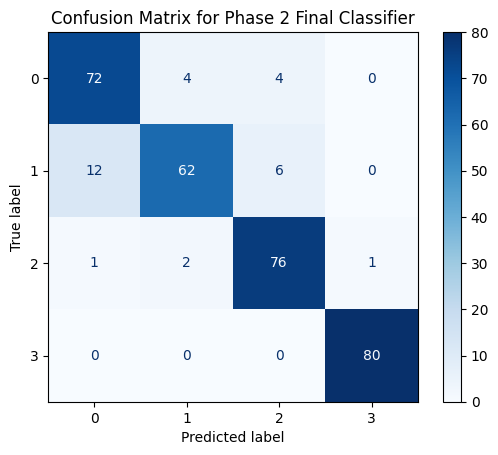

In [29]:
 #load the model
loaded_model = joblib.load("phase_2_final_model_pipeline.pkl")
#make predictions
y_pred = best_model.predict(X_test)
#generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
#add class lables
class_labels = np.unique(y_test)
#print out confusion matrix
print("Confusion Matrix:")
print(cm)
#display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Phase 2 Final Classifier")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


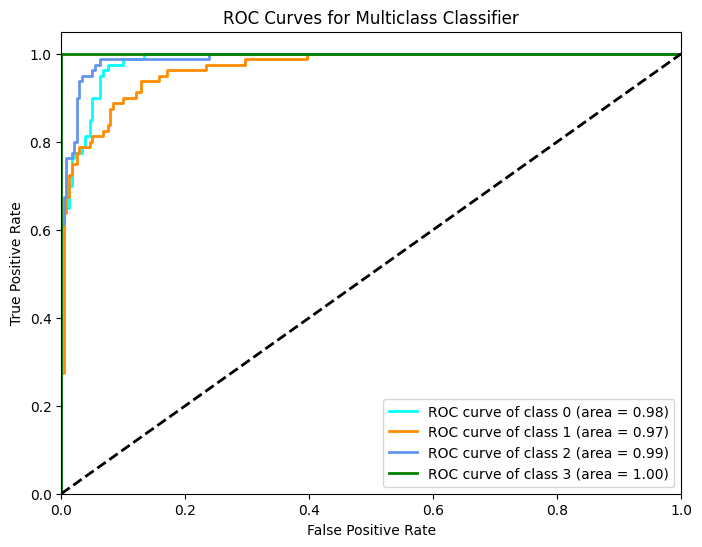

In [34]:
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_model.predict_proba(X_test)

#compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot curves
plt.figure(figsize=(8, 6))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classifier')
plt.legend(loc="lower right")
plt.show()